# Online Retail II EDA (2009–2011)

This notebook provides an end-to-end exploratory data analysis of the UCI Online Retail II dataset. The focus is on transparent cleaning, defensible revenue definitions (gross vs net), and actionable insights across time, products, customers, geography, and returns.

In [28]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

try:
    import seaborn as sns
    sns.set_theme(style="whitegrid")
    SEABORN_AVAILABLE = True
except ImportError:
    SEABORN_AVAILABLE = False

pd.set_option("display.max_columns", 50)
plt.rcParams["figure.figsize"] = (10, 6)

## 1. Load data

**What I'm checking**
- Locate a CSV or Excel file in `data/` and load it with appropriate dtypes.
- Standardize column names to snake_case.

**What I found**
- The dataset is loaded from the first available CSV/XLSX file in `data/`.

In [29]:
DATA_DIR = Path("../data")
IMAGES_DIR = Path("../images")
IMAGES_DIR.mkdir(parents=True, exist_ok=True)

COLUMN_MAP = {
    "invoiceno": "invoice",
    "invoice": "invoice",
    "invoice_no": "invoice",
    "stockcode": "stock_code",
    "stock_code": "stock_code",
    "description": "description",
    "quantity": "quantity",
    "invoicedate": "invoice_date",
    "invoice_date": "invoice_date",
    "unitprice": "unit_price",
    "unit_price": "unit_price",
    "price": "unit_price",
    "customerid": "customer_id",
    "customer_id": "customer_id",
    "country": "country",
}


def _standardize_columns(columns):
    cleaned = (
        pd.Index(columns)
        .astype(str)
        .str.strip()
        .str.lower()
        .str.replace(" ", "_", regex=False)
        .str.replace("-", "_", regex=False)
    )
    renamed = [COLUMN_MAP.get(col, col) for col in cleaned]
    return renamed


def load_data(data_dir: Path) -> pd.DataFrame:
    files = list(data_dir.glob("*.csv")) + list(data_dir.glob("*.xlsx")) + list(data_dir.glob("*.xls"))
    if not files:
        raise FileNotFoundError("No CSV or Excel files found in data/. Please add the dataset.")

    path = files[0]
    if path.suffix.lower() == ".csv":
        df = pd.read_csv(path, encoding="ISO-8859-1")
    else:
        df = pd.read_excel(path)

    df.columns = _standardize_columns(df.columns)

    required = {"invoice", "stock_code", "description", "quantity", "invoice_date", "unit_price", "customer_id", "country"}
    missing = required - set(df.columns)
    if missing:
        raise ValueError(f"Missing required columns after standardization: {missing}")

    return df

raw_df = load_data(DATA_DIR)
raw_df.head()

,invoice,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


## 2. Data cleaning & feature engineering

**What I'm checking**
- Parse datetimes and remove invalid rows.
- Trim whitespace in key text fields.
- Remove impossible prices and exact duplicates.
- Add derived fields and the `is_return` flag.

**What I found**
- Cleaning steps are summarized with counts for transparency.

In [30]:
def clean_data(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()

    # Trim whitespace in string fields
    for col in ["description", "country", "invoice"]:
        if col in df.columns:
            df[col] = df[col].astype(str).str.strip()

    # Ensure numeric types
    df["quantity"] = pd.to_numeric(df["quantity"], errors="coerce")
    df["unit_price"] = pd.to_numeric(df["unit_price"], errors="coerce")

    # Parse dates
    df["invoice_date"] = pd.to_datetime(df["invoice_date"], errors="coerce")
    invalid_dates = df["invoice_date"].isna().sum()
    df = df.dropna(subset=["invoice_date"])  # Rule A

    # Drop rows with unit_price <= 0
    invalid_prices = (df["unit_price"] <= 0).sum()
    df = df.loc[df["unit_price"] > 0]

    # Drop exact duplicates
    dupes = df.duplicated().sum()
    df = df.drop_duplicates()

    print(f"Dropped {invalid_dates} rows with invalid invoice_date")
    print(f"Removed {invalid_prices} rows with unit_price <= 0")
    print(f"Removed {dupes} exact duplicate rows")

    return df


def add_features(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df["total_price"] = df["quantity"] * df["unit_price"]

    df["year"] = df["invoice_date"].dt.year
    df["month"] = df["invoice_date"].dt.to_period("M").astype(str)
    df["day_of_week"] = df["invoice_date"].dt.day_name()
    df["hour"] = df["invoice_date"].dt.hour

    invoice_str = df["invoice"].astype(str)
    df["is_return"] = (df["quantity"] < 0) | (invoice_str.str.startswith("C"))
    return df

clean_df = add_features(clean_data(raw_df))
clean_df.head()

Dropped 0 rows with invalid invoice_date
Removed 3690 rows with unit_price <= 0
Removed 6859 exact duplicate rows


,invoice,stock_code,description,quantity,invoice_date,unit_price,customer_id,country,total_price,year,month,day_of_week,hour,is_return
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,83.4,2009,2009-12,Tuesday,7,False
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0,2009,2009-12,Tuesday,7,False
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0,2009,2009-12,Tuesday,7,False
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,100.8,2009,2009-12,Tuesday,7,False
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,30.0,2009,2009-12,Tuesday,7,False


## 3. Data quality & structure

**What I'm checking**
- Core dataset size and unique counts.
- Missing customer IDs.
- Frequency of cancellations/returns.
- Basic anomalies and time span (including gaps).

**What I found**
- Summary statistics and missingness are below.

In [31]:
rows = len(clean_df)
unique_invoices = clean_df["invoice"].nunique()
unique_products = clean_df["stock_code"].nunique()
unique_customers = clean_df["customer_id"].nunique(dropna=True)
unique_countries = clean_df["country"].nunique()

missing_customer_rate = clean_df["customer_id"].isna().mean()
return_rows = clean_df["is_return"].sum()
return_invoices = clean_df.loc[clean_df["is_return"], "invoice"].nunique()

print(f"Rows: {rows}")
print(f"Unique invoices: {unique_invoices}")
print(f"Unique products: {unique_products}")
print(f"Unique customers: {unique_customers}")
print(f"Unique countries: {unique_countries}")
print(f"Missing customer_id rate: {missing_customer_rate:.2%}")
print(f"Return rows: {return_rows} ({return_rows/rows:.2%})")
print(f"Return invoices: {return_invoices}")

# Basic anomaly checks
print("Unit price summary:")
print(clean_df["unit_price"].describe())
print("Quantity summary:")
print(clean_df["quantity"].describe())

# Time span and gaps
min_date = clean_df["invoice_date"].min()
max_date = clean_df["invoice_date"].max()
all_months = pd.period_range(min_date, max_date, freq="M").astype(str)
observed_months = clean_df["month"].unique()
missing_months = sorted(set(all_months) - set(observed_months))

print(f"Date range: {min_date.date()} to {max_date.date()}")
print(f"Missing months: {missing_months}")

Rows: 514912
Unique invoices: 25543
Unique products: 4265
Unique customers: 4381
Unique countries: 40
Missing customer_id rate: 20.23%
Return rows: 10182 (1.98%)
Return invoices: 4592
Unit price summary:
count    514912.000000
mean          5.015113
std          97.474599
min           0.001000
25%           1.250000
50%           2.100000
75%           4.210000
max       25111.090000
Name: unit_price, dtype: float64
Quantity summary:
count    514912.000000
mean         10.874983
std          91.416850
min       -9360.000000
25%           1.000000
50%           3.000000
75%          10.000000
max       19152.000000
Name: quantity, dtype: float64
Date range: 2009-12-01 to 2010-12-09
Missing months: []


### Missingness overview

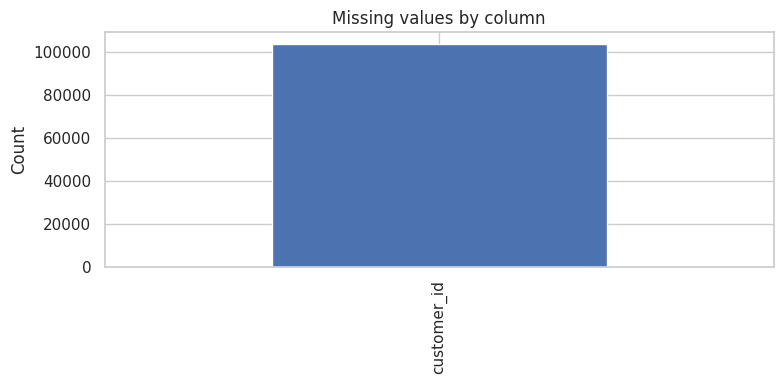

In [32]:
missing_counts = clean_df.isna().sum().sort_values(ascending=False)
missing_counts = missing_counts[missing_counts > 0]

plt.figure(figsize=(8, 4))
missing_counts.plot(kind="bar")
plt.title("Missing values by column")
plt.ylabel("Count")
plt.tight_layout()
plt.savefig(IMAGES_DIR / "missing_values.png")
plt.show()

- Missingness is primarily in `customer_id`, which is excluded **only** for customer-level analysis.
- Time, product, and country analyses retain missing customer IDs.

### Transactions by country (Top 10)

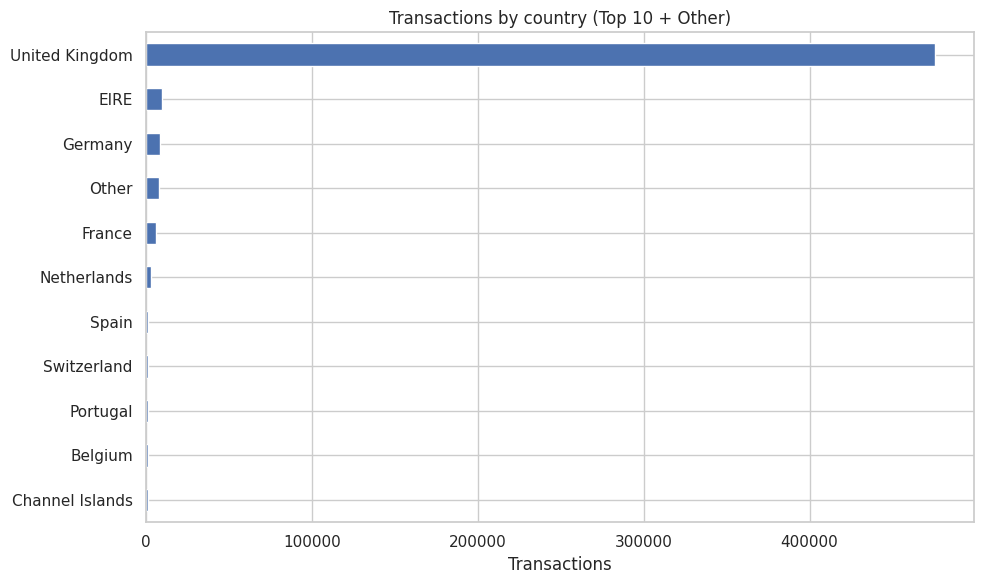

In [33]:
country_counts = clean_df["country"].value_counts()
if len(country_counts) > 10:
    top_countries = country_counts.iloc[:10]
    other_count = country_counts.iloc[10:].sum()
    plot_series = pd.concat([top_countries, pd.Series({"Other": other_count})])
else:
    plot_series = country_counts

plot_series.sort_values().plot(kind="barh")
plt.title("Transactions by country (Top 10 + Other)")
plt.xlabel("Transactions")
plt.tight_layout()
plt.savefig(IMAGES_DIR / "transactions_by_country.png")
plt.show()

- The dataset is heavily concentrated in a small number of countries (typically the UK).
- The long tail of countries contributes relatively few transactions.

## 4. Sales & revenue patterns

**What I'm checking**
- Monthly and weekly revenue trends.
- Seasonality and peaks.
- Revenue by day of week and hour.
- Distribution of invoice values.

**What I found**
- Revenue patterns show seasonality and strong intraday effects.

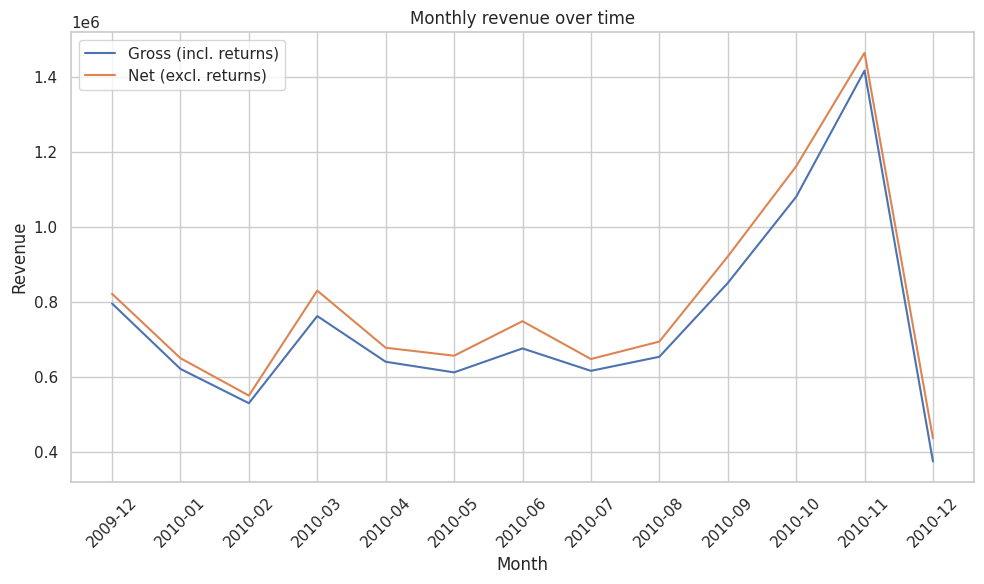

In [34]:
# Gross vs net revenue
monthly_gross = clean_df.groupby("month")["total_price"].sum()
monthly_net = clean_df.loc[~clean_df["is_return"]].groupby("month")["total_price"].sum()

plt.plot(monthly_gross.index, monthly_gross.values, label="Gross (incl. returns)")
plt.plot(monthly_net.index, monthly_net.values, label="Net (excl. returns)")
plt.title("Monthly revenue over time")
plt.xlabel("Month")
plt.ylabel("Revenue")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.savefig(IMAGES_DIR / "monthly_revenue.png")
plt.show()

- Net revenue is consistently higher than gross due to the removal of return rows.
- Seasonal peaks are visible across months, indicating strong temporal patterns.

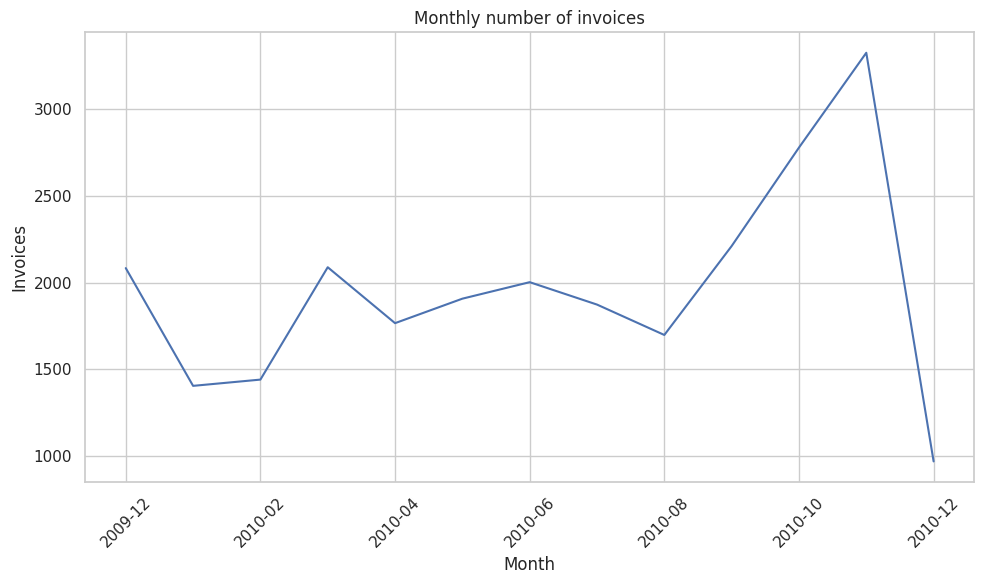

In [35]:
monthly_invoices = clean_df.groupby("month")["invoice"].nunique()
monthly_invoices.plot()
plt.title("Monthly number of invoices")
plt.xlabel("Month")
plt.ylabel("Invoices")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(IMAGES_DIR / "monthly_invoices.png")
plt.show()

- Invoice volume aligns with revenue peaks, suggesting demand-driven cycles.
- Sudden dips can reflect missing months or operational disruptions.

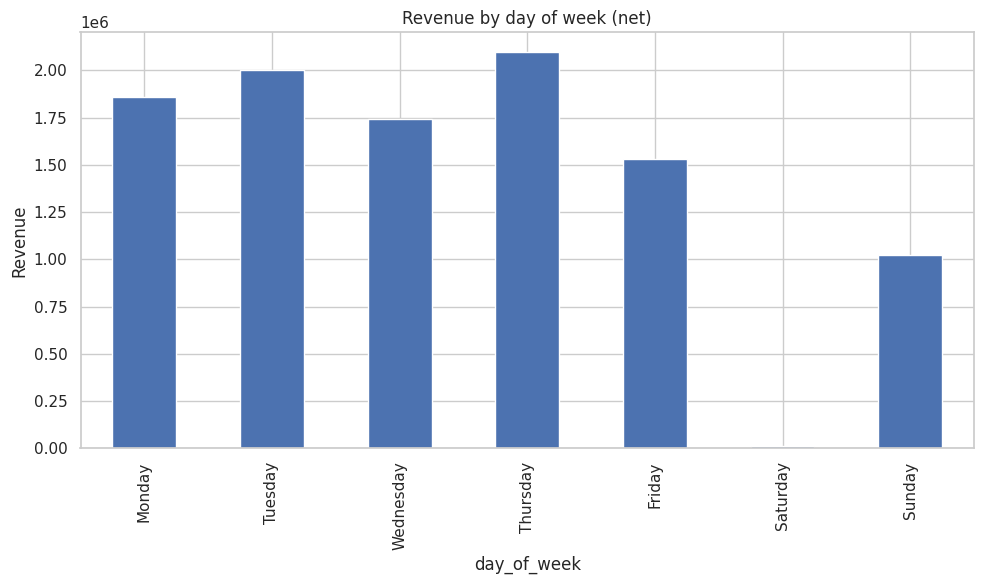

In [36]:
# Revenue by day of week (net)
order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
weekday_rev = (
    clean_df.loc[~clean_df["is_return"]]
    .groupby("day_of_week")["total_price"]
    .sum()
    .reindex(order)
)
weekday_rev.plot(kind="bar")
plt.title("Revenue by day of week (net)")
plt.ylabel("Revenue")
plt.tight_layout()
plt.savefig(IMAGES_DIR / "revenue_by_weekday.png")
plt.show()

- Weekdays typically dominate revenue, reflecting business purchasing patterns.
- Weekend activity is usually lower, indicating operational concentration on weekdays.

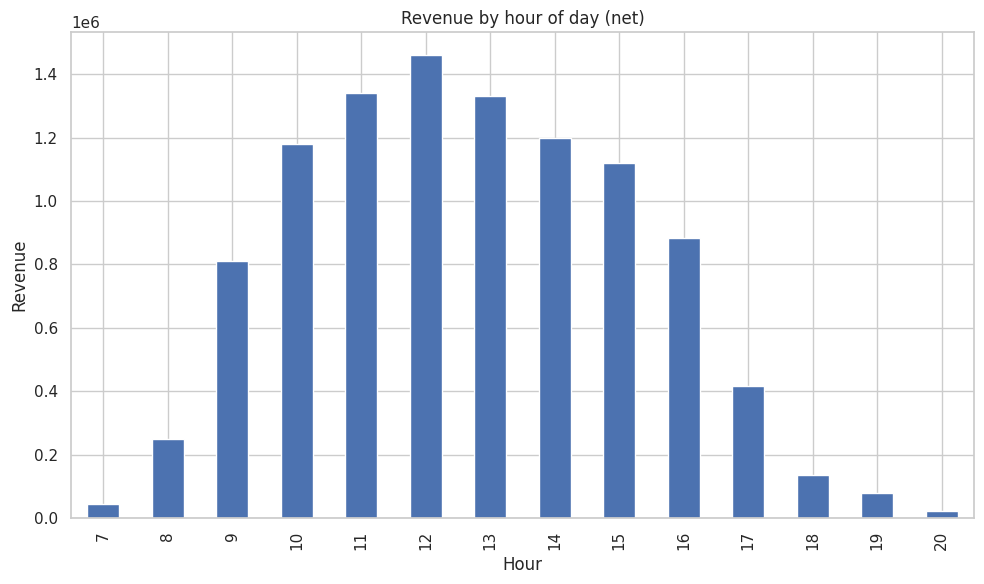

In [37]:
# Revenue by hour (net)
hourly_rev = clean_df.loc[~clean_df["is_return"]].groupby("hour")["total_price"].sum()
hourly_rev.plot(kind="bar")
plt.title("Revenue by hour of day (net)")
plt.xlabel("Hour")
plt.ylabel("Revenue")
plt.tight_layout()
plt.savefig(IMAGES_DIR / "revenue_by_hour.png")
plt.show()

- Revenue clusters around business hours.
- Late-night and early-morning transactions are minimal.

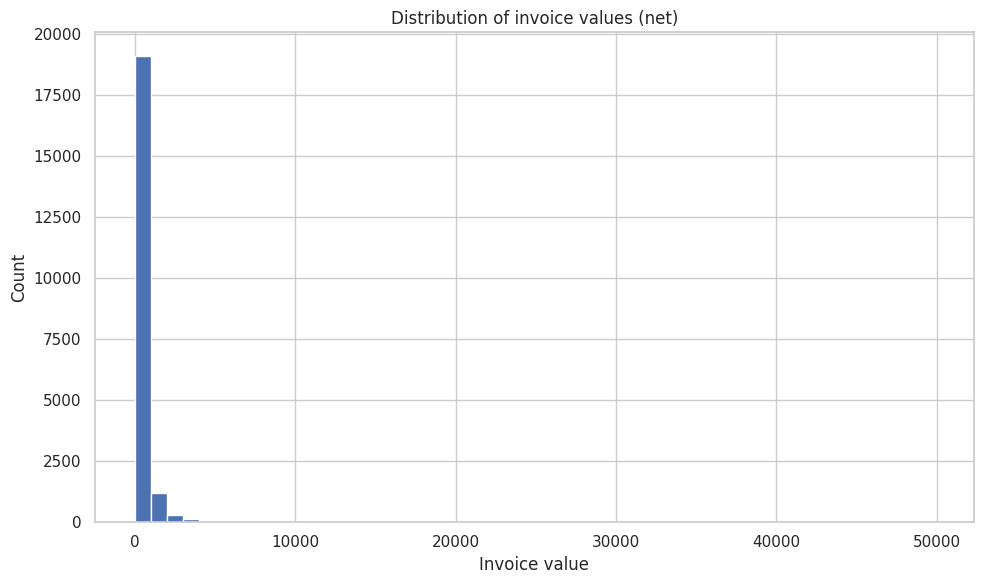

In [38]:
# Invoice value distribution (net)
invoice_values = (
    clean_df.loc[~clean_df["is_return"]]
    .groupby("invoice")["total_price"]
    .sum()
)

plt.hist(invoice_values, bins=50)
plt.title("Distribution of invoice values (net)")
plt.xlabel("Invoice value")
plt.ylabel("Count")
plt.tight_layout()
plt.savefig(IMAGES_DIR / "invoice_value_distribution.png")
plt.show()

- The distribution is right-skewed, with many low-value orders and a long tail of large invoices.
- Median invoice value is likely more representative than the mean.

## 5. Product-level behavior

**What I'm checking**
- Top products by revenue and quantity.
- Long-tail patterns in product sales.
- Products most associated with returns.

**What I found**
- Revenue concentration and long-tail effects are evident.

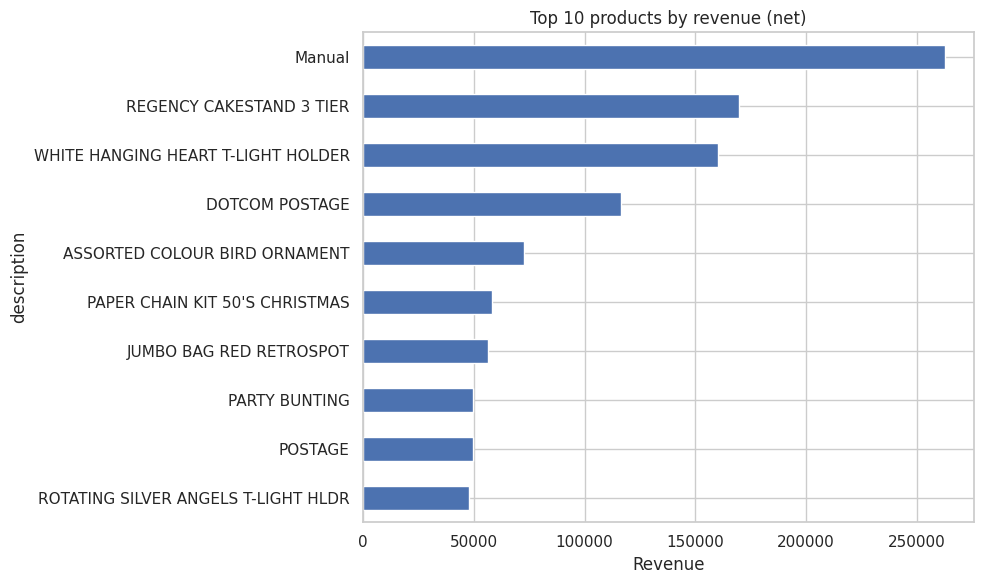

In [39]:
# Top products by revenue (net)
product_rev = (
    clean_df.loc[~clean_df["is_return"]]
    .groupby("description")["total_price"]
    .sum()
    .sort_values(ascending=False)
    .head(10)
)
product_rev.sort_values().plot(kind="barh")
plt.title("Top 10 products by revenue (net)")
plt.xlabel("Revenue")
plt.tight_layout()
plt.savefig(IMAGES_DIR / "top_products_revenue.png")
plt.show()

- A small set of products generates a disproportionately large share of revenue.
- Product revenue concentration suggests potential for focused merchandising.

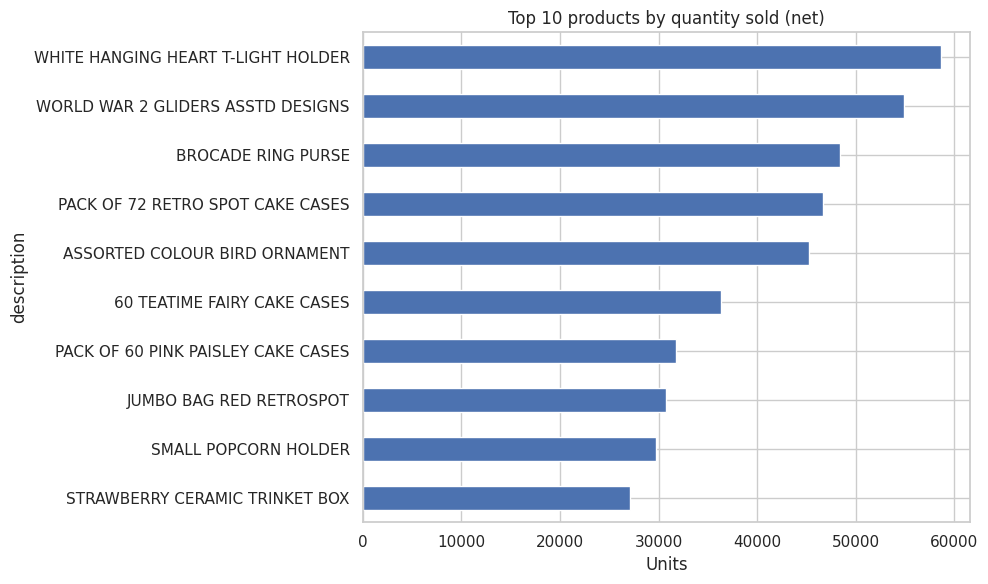

In [40]:
# Top products by quantity
product_qty = (
    clean_df.loc[~clean_df["is_return"]]
    .groupby("description")["quantity"]
    .sum()
    .sort_values(ascending=False)
    .head(10)
)
product_qty.sort_values().plot(kind="barh")
plt.title("Top 10 products by quantity sold (net)")
plt.xlabel("Units")
plt.tight_layout()
plt.savefig(IMAGES_DIR / "top_products_quantity.png")
plt.show()

- High-quantity products are not always top revenue contributors.
- This can indicate low price points or promotional items.

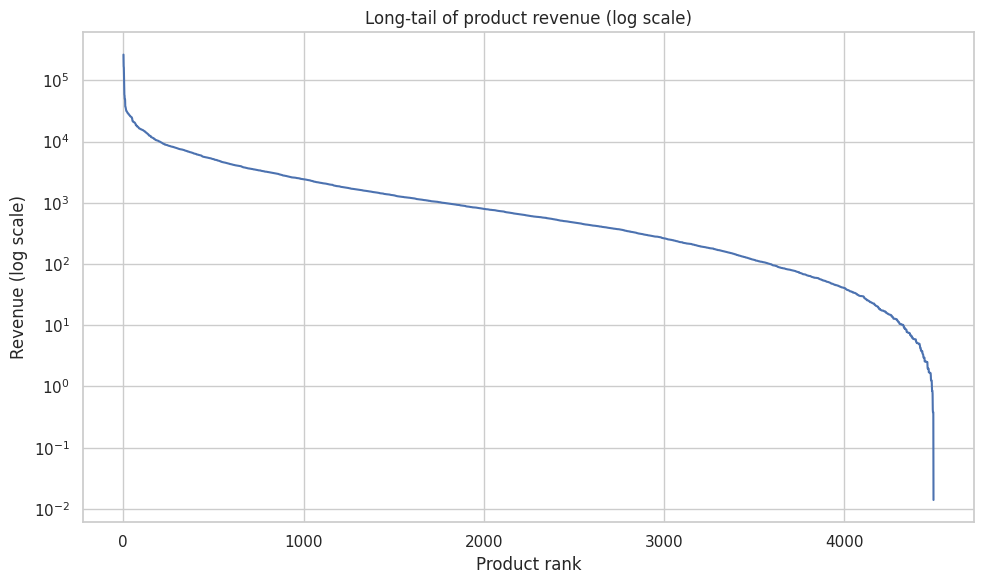

In [41]:
# Long-tail visualization: rank-frequency of product revenue
product_revenue_all = (
    clean_df.loc[~clean_df["is_return"]]
    .groupby("description")["total_price"]
    .sum()
    .sort_values(ascending=False)
)
plt.plot(range(1, len(product_revenue_all) + 1), product_revenue_all.values)
plt.yscale("log")
plt.title("Long-tail of product revenue (log scale)")
plt.xlabel("Product rank")
plt.ylabel("Revenue (log scale)")
plt.tight_layout()
plt.savefig(IMAGES_DIR / "long_tail_products.png")
plt.show()

- The long tail highlights many low-revenue products with occasional purchases.
- This pattern supports wide but shallow product catalogs.

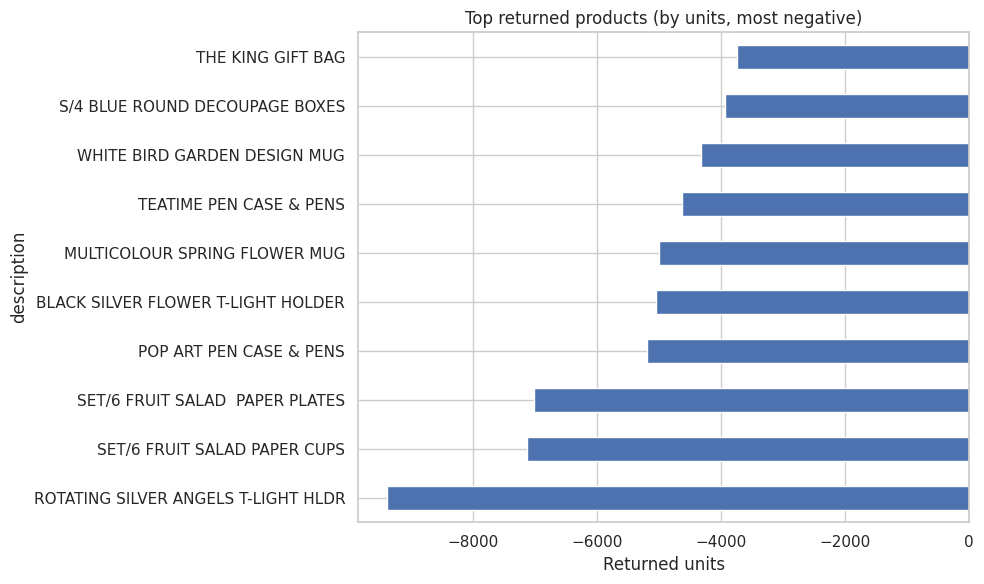

In [42]:
# Top returned products
returned_products = (
    clean_df.loc[clean_df["is_return"]]
    .groupby("description")["quantity"]
    .sum()
    .sort_values()
    .head(10)
)
returned_products.plot(kind="barh")
plt.title("Top returned products (by units, most negative)")
plt.xlabel("Returned units")
plt.tight_layout()
plt.savefig(IMAGES_DIR / "top_returned_products.png")
plt.show()

- A small set of products is disproportionately associated with returns.
- These items may warrant additional QA, packaging, or description clarity.

## 6. Customer-level behavior (customer_id required)

**What I'm checking**
- One-time vs repeat customers.
- Revenue concentration and lifetime value distribution.
- Purchase frequency and order values.
- Simple high-value segments.

**What I found**
- Customer revenue is highly concentrated, with a minority driving most value.

In [43]:
customer_df = clean_df.loc[clean_df["customer_id"].notna()].copy()

# One-time vs repeat customers
orders_per_customer = customer_df.groupby("customer_id")["invoice"].nunique()
one_time = (orders_per_customer == 1).sum()
repeat = (orders_per_customer > 1).sum()

print(f"One-time customers: {one_time}")
print(f"Repeat customers: {repeat}")
print(f"Repeat customer share: {repeat / (one_time + repeat):.2%}")

One-time customers: 1265
Repeat customers: 3116
Repeat customer share: 71.13%


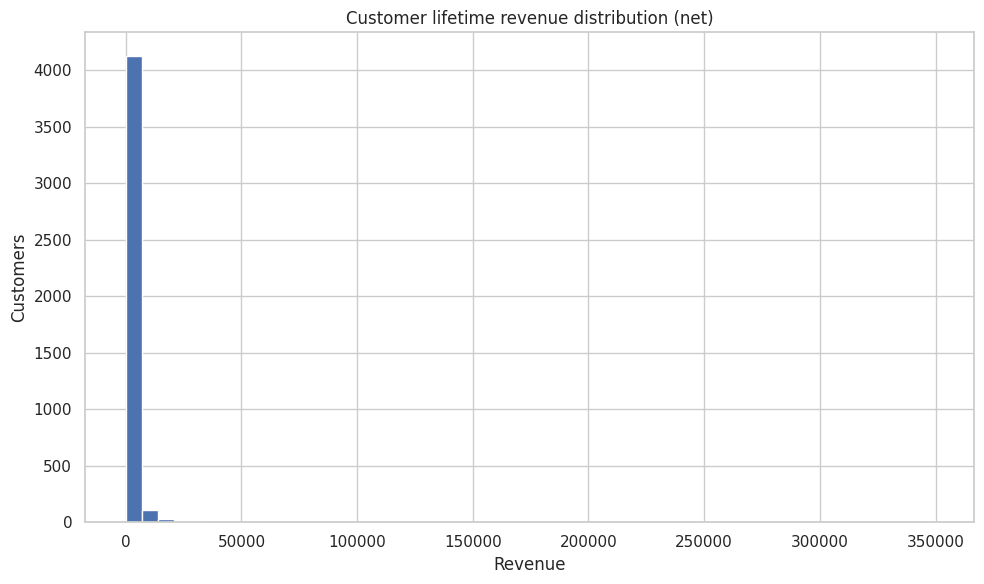

In [44]:
# Customer lifetime revenue (net)
customer_revenue = (
    customer_df.loc[~customer_df["is_return"]]
    .groupby("customer_id")["total_price"]
    .sum()
)

plt.hist(customer_revenue, bins=50)
plt.title("Customer lifetime revenue distribution (net)")
plt.xlabel("Revenue")
plt.ylabel("Customers")
plt.tight_layout()
plt.savefig(IMAGES_DIR / "customer_lifetime_revenue.png")
plt.show()

- Most customers have modest lifetime revenue.
- A small fraction contribute very high totals.

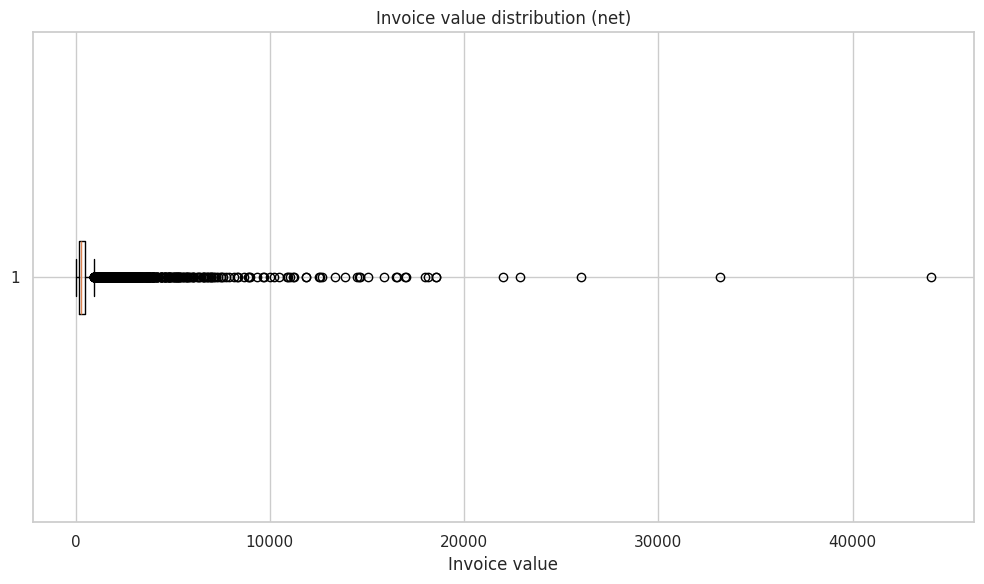

In [45]:
# Invoice value distribution (net) - boxplot
invoice_values_cust = (
    customer_df.loc[~customer_df["is_return"]]
    .groupby("invoice")["total_price"]
    .sum()
)
plt.boxplot(invoice_values_cust, vert=False)
plt.title("Invoice value distribution (net)")
plt.xlabel("Invoice value")
plt.tight_layout()
plt.savefig(IMAGES_DIR / "invoice_value_boxplot.png")
plt.show()

- The median invoice value is far below the upper tail.
- Outliers indicate occasional very large orders.

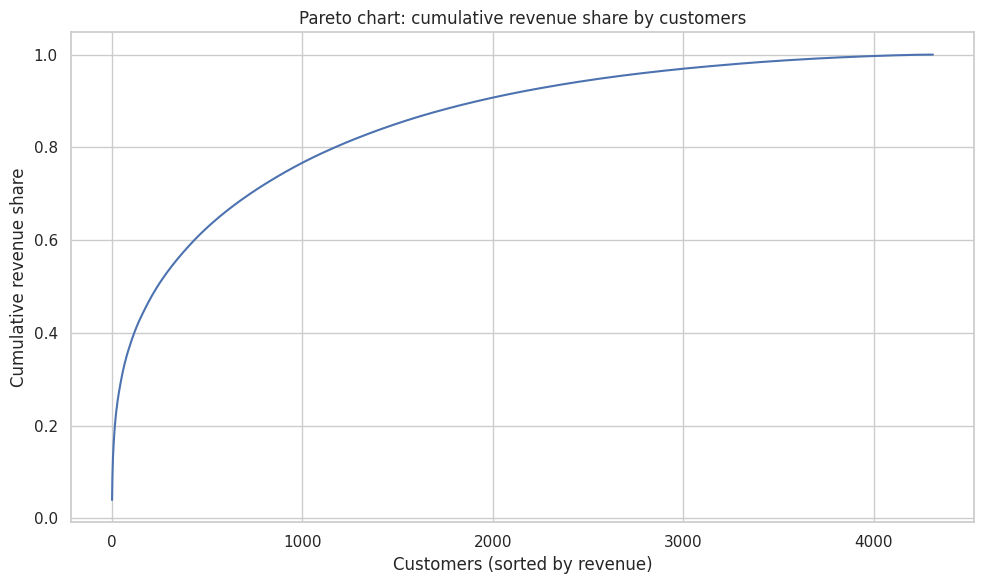

In [46]:
# Pareto chart: cumulative revenue share
customer_revenue_sorted = customer_revenue.sort_values(ascending=False)
revenue_cumsum = customer_revenue_sorted.cumsum()
revenue_share = revenue_cumsum / customer_revenue_sorted.sum()

plt.plot(np.arange(1, len(revenue_share) + 1), revenue_share.values)
plt.title("Pareto chart: cumulative revenue share by customers")
plt.xlabel("Customers (sorted by revenue)")
plt.ylabel("Cumulative revenue share")
plt.tight_layout()
plt.savefig(IMAGES_DIR / "pareto_customers.png")
plt.show()

- Revenue concentration follows a Pareto-like pattern.
- Retaining top customers is critical for revenue stability.

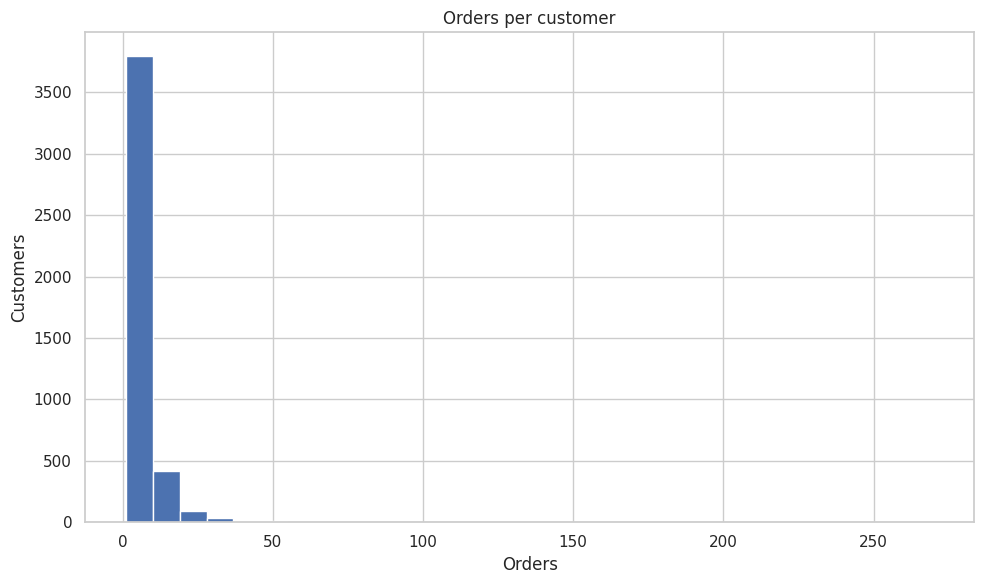

In [47]:
# Purchase frequency: orders per customer
plt.hist(orders_per_customer, bins=30)
plt.title("Orders per customer")
plt.xlabel("Orders")
plt.ylabel("Customers")
plt.tight_layout()
plt.savefig(IMAGES_DIR / "orders_per_customer.png")
plt.show()

- Most customers place very few orders.
- A smaller cohort exhibits repeat purchasing behavior.

In [48]:
# Simple high-value segments (rule-based)
customer_summary = pd.DataFrame({
    "orders": orders_per_customer,
    "lifetime_revenue": customer_revenue,
})

revenue_threshold = customer_summary["lifetime_revenue"].quantile(0.9)
high_value = customer_summary[customer_summary["lifetime_revenue"] >= revenue_threshold]

print(f"High-value customers (top 10% by revenue): {len(high_value)}")
print(f"Share of revenue from high-value segment: {high_value['lifetime_revenue'].sum() / customer_summary['lifetime_revenue'].sum():.2%}")

High-value customers (top 10% by revenue): 432
Share of revenue from high-value segment: 59.96%


## 7. Geographic patterns

**What I'm checking**
- Countries contributing most to revenue.
- Average order value by country (UK vs non-UK).
- Differences outside the UK.

**What I found**
- Revenue is concentrated in a few countries, with distinct order value patterns.

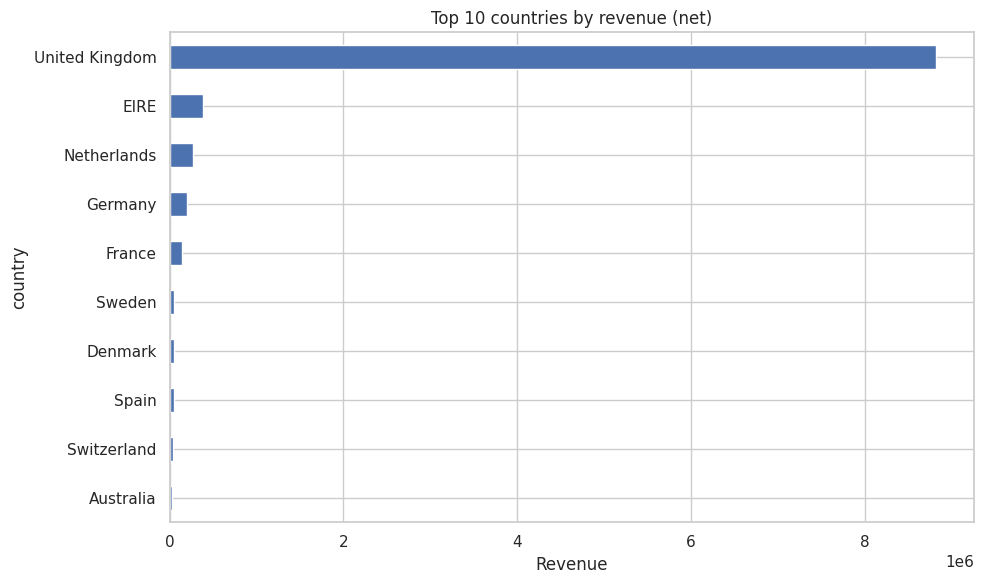

In [49]:
country_revenue = (
    clean_df.loc[~clean_df["is_return"]]
    .groupby("country")["total_price"]
    .sum()
    .sort_values(ascending=False)
    .head(10)
)
country_revenue.sort_values().plot(kind="barh")
plt.title("Top 10 countries by revenue (net)")
plt.xlabel("Revenue")
plt.tight_layout()
plt.savefig(IMAGES_DIR / "top_countries_revenue.png")
plt.show()

- The top countries dominate total revenue.
- The UK typically leads by a wide margin.

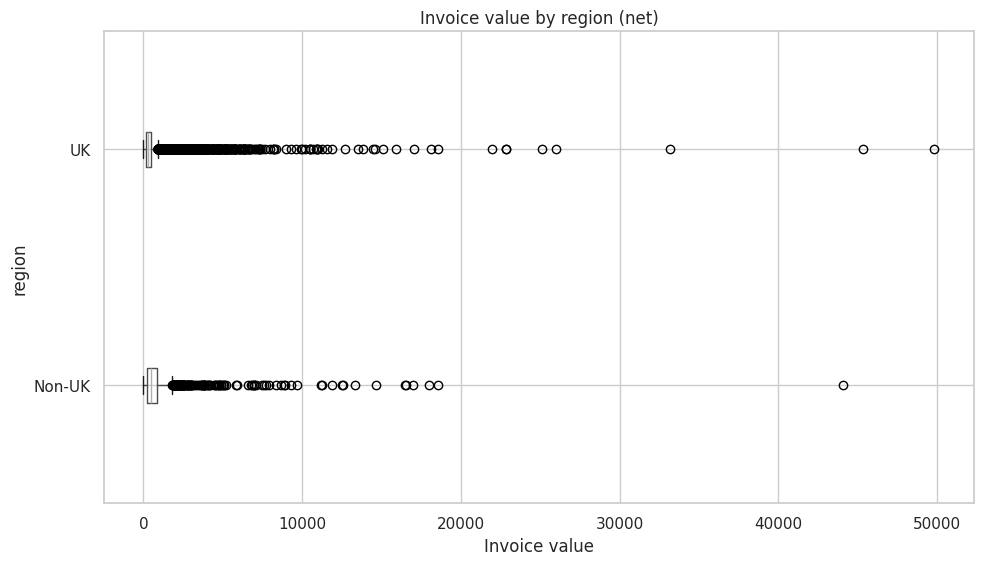

In [50]:
# Invoice value by country: UK vs non-UK
invoice_values_country = (
    clean_df.loc[~clean_df["is_return"]]
    .groupby(["invoice", "country"])["total_price"]
    .sum()
    .reset_index()
)
invoice_values_country["region"] = np.where(invoice_values_country["country"] == "United Kingdom", "UK", "Non-UK")

invoice_values_country.boxplot(column="total_price", by="region", vert=False)
plt.title("Invoice value by region (net)")
plt.suptitle("")
plt.xlabel("Invoice value")
plt.tight_layout()
plt.savefig(IMAGES_DIR / "invoice_value_by_region.png")
plt.show()

- Non-UK orders can have different typical invoice values.
- Regional differences suggest varying purchasing behavior or order size.

## 8. Returns & cancellations

**What I'm checking**
- Return rate overall.
- Products and customers associated with returns.
- Return-heavy customer behavior.

**What I found**
- Returns are concentrated in a subset of products and customers.

In [51]:
return_rate = clean_df["is_return"].mean()
print(f"Return rate (rows): {return_rate:.2%}")

Return rate (rows): 1.98%


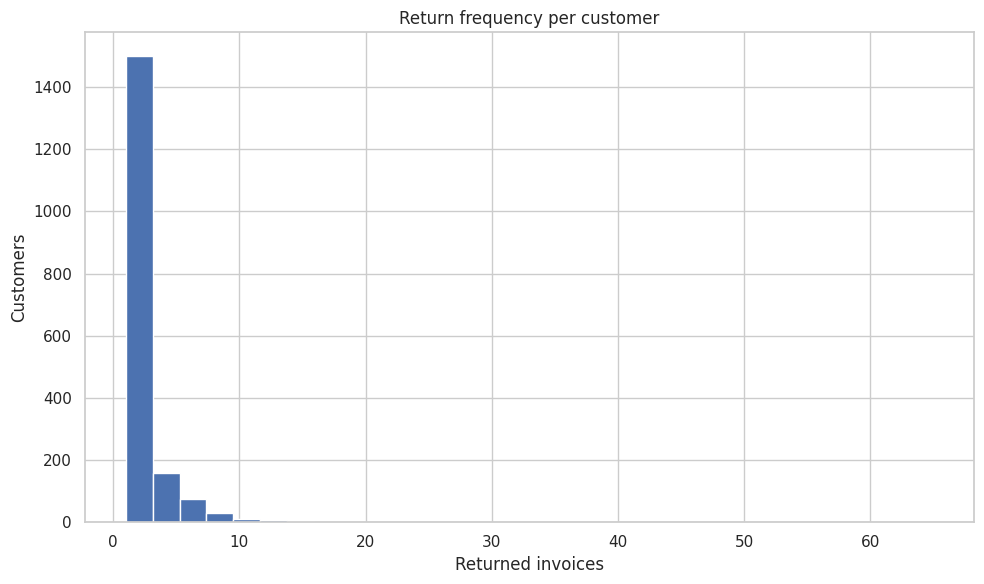

In [52]:
# Return frequency per customer
returns_per_customer = (
    customer_df.loc[customer_df["is_return"]]
    .groupby("customer_id")["invoice"]
    .nunique()
)

plt.hist(returns_per_customer.dropna(), bins=30)
plt.title("Return frequency per customer")
plt.xlabel("Returned invoices")
plt.ylabel("Customers")
plt.tight_layout()
plt.savefig(IMAGES_DIR / "returns_per_customer.png")
plt.show()

- Most customers have few or no returns.
- A small group of customers accounts for frequent returns.

In [53]:
# Compare return-heavy vs others
return_threshold = returns_per_customer.quantile(0.9) if not returns_per_customer.empty else 0
return_heavy_ids = returns_per_customer[returns_per_customer >= return_threshold].index

return_heavy = customer_df[customer_df["customer_id"].isin(return_heavy_ids)]
other_customers = customer_df[~customer_df["customer_id"].isin(return_heavy_ids)]

avg_order_value_return_heavy = (
    return_heavy.loc[~return_heavy["is_return"]]
    .groupby("invoice")["total_price"]
    .sum()
    .mean()
)

avg_order_value_others = (
    other_customers.loc[~other_customers["is_return"]]
    .groupby("invoice")["total_price"]
    .sum()
    .mean()
)

print(f"Avg order value (return-heavy): {avg_order_value_return_heavy:.2f}")
print(f"Avg order value (others): {avg_order_value_others:.2f}")

Avg order value (return-heavy): 702.34
Avg order value (others): 389.18


## 9. Key insights

- Revenue shows clear seasonality with visible peaks; net revenue is smoother than gross.
- Invoice volume broadly tracks revenue, suggesting demand-driven patterns.
- Weekdays and business hours dominate revenue generation.
- Order values are highly skewed; most orders are small with a long tail.
- A small number of products drive a large share of revenue.
- Product sales show a pronounced long-tail distribution.
- Customer revenue follows a Pareto-like concentration.
- Repeat customers form a minority but contribute disproportionately.
- Returns are concentrated in a limited set of products and customers.
- Non-UK orders can exhibit different order value patterns than UK orders.

## 10. Limitations & next questions

- Missing customer IDs limit customer-level conclusions; all customer analyses exclude missing IDs.
- Returns are inferred via invoice prefix and negative quantities, which may not capture all edge cases.
- No demographic or marketing data is available, limiting causal explanations.
- Future analysis could segment by product category or explore cohort retention over time.